In [142]:
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import os
import numpy as np
import pandas as pd
from astropy.io import fits
from spectres import spectres
from scipy.signal import savgol_filter
from tqdm import tqdm  # Progress bar for loop

def resample_spectra(new_wavs, spec_wavs, savgol_data):
    """Resample spectra to a new wavelength grid."""
    return spectres(new_wavs=new_wavs, spec_wavs=spec_wavs, spec_fluxes=savgol_data, fill=0, verbose=False)

def normalize(raw_data):
    """Normalize flux data by the maximum value."""
    return raw_data / raw_data.max() if raw_data.max() != 0 else raw_data

def savgol_smooth(data, window_length=5, polyorder=3):
    """Apply Savitzky-Golay smoothing filter."""
    return savgol_filter(data, window_length=window_length, polyorder=polyorder, mode='nearest')

In [144]:
hdul = fits.open('DESI_EDR_SPECTRA.fits')
data = hdul[1].data

Fluxes0 = data.FLUX_ORIG
wavelength0 = data.WAVE_ORIG[0]

Fluxes = np.array([i[100:-100] for i in data.FLUX_ORIG]).byteswap().newbyteorder()
wavelength = np.array(data.WAVE_ORIG[0][100:-100]).byteswap().newbyteorder()

new_wavs = np.arange(3712, 9721, 5)

def flux_processor(flux, wavelength,wl):
        flux_resampled = resample_spectra(new_wavs=new_wavs, spec_wavs=wavelength, savgol_data=flux)
        flux_smooth = savgol_smooth(flux_resampled, window_length=wl, polyorder=3)
        flux_smooth = flux_smooth/max(flux_smooth)

        return flux_smooth


clearn_fluxes = [flux_processor(i,wavelength,10) for i in Fluxes]
df = pd.DataFrame(clearn_fluxes,columns=new_wavs)
df['ZC'] = np.array(data.CORRECT_Z).byteswap().newbyteorder()
df['ZP'] = np.array(data.PIPELINE_Z).byteswap().newbyteorder()
df['STC'] = np.array(data.CORRECT_SPECTYPE).byteswap().newbyteorder()
df['STP'] = np.array(data.PIPELINE_SPECTYPE).byteswap().newbyteorder()

df = df.dropna()

/tmp/ipykernel_120954/4049475144.py:15: RuntimeWarning: invalid value encountered in divide
  flux_smooth = flux_smooth/max(flux_smooth)


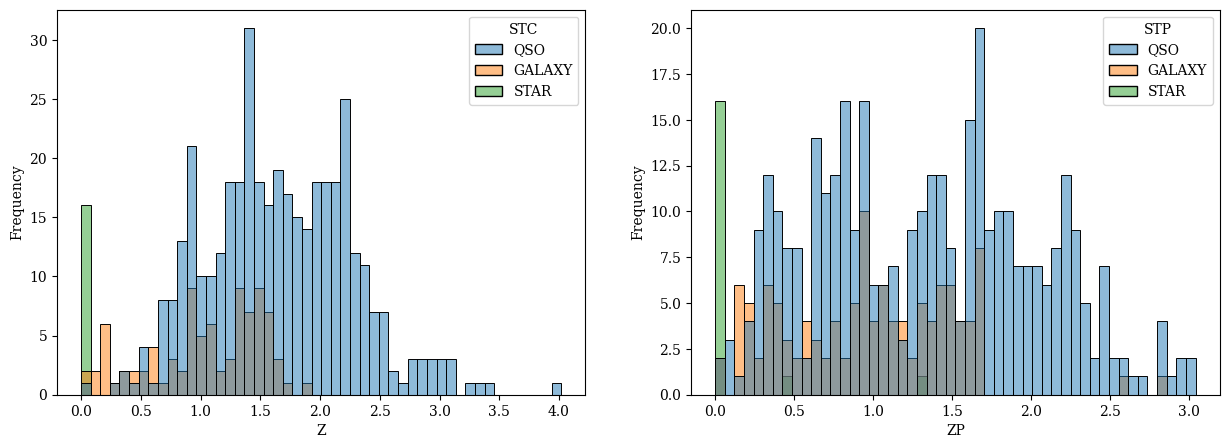

In [145]:
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']

plt.subplots(1,2,figsize=(15,5))
plt.subplot(1,2,1)
sns.histplot(df,x='ZC',hue='STC',fill=True,bins=50,alpha=0.5)
plt.xlabel('Z')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
sns.histplot(df,x='ZP',hue='STP',fill=True,bins=50,alpha=0.5)
plt.ylabel('Frequency')
plt.show()

In [146]:
df.to_csv('Spectra.csv',index=False)

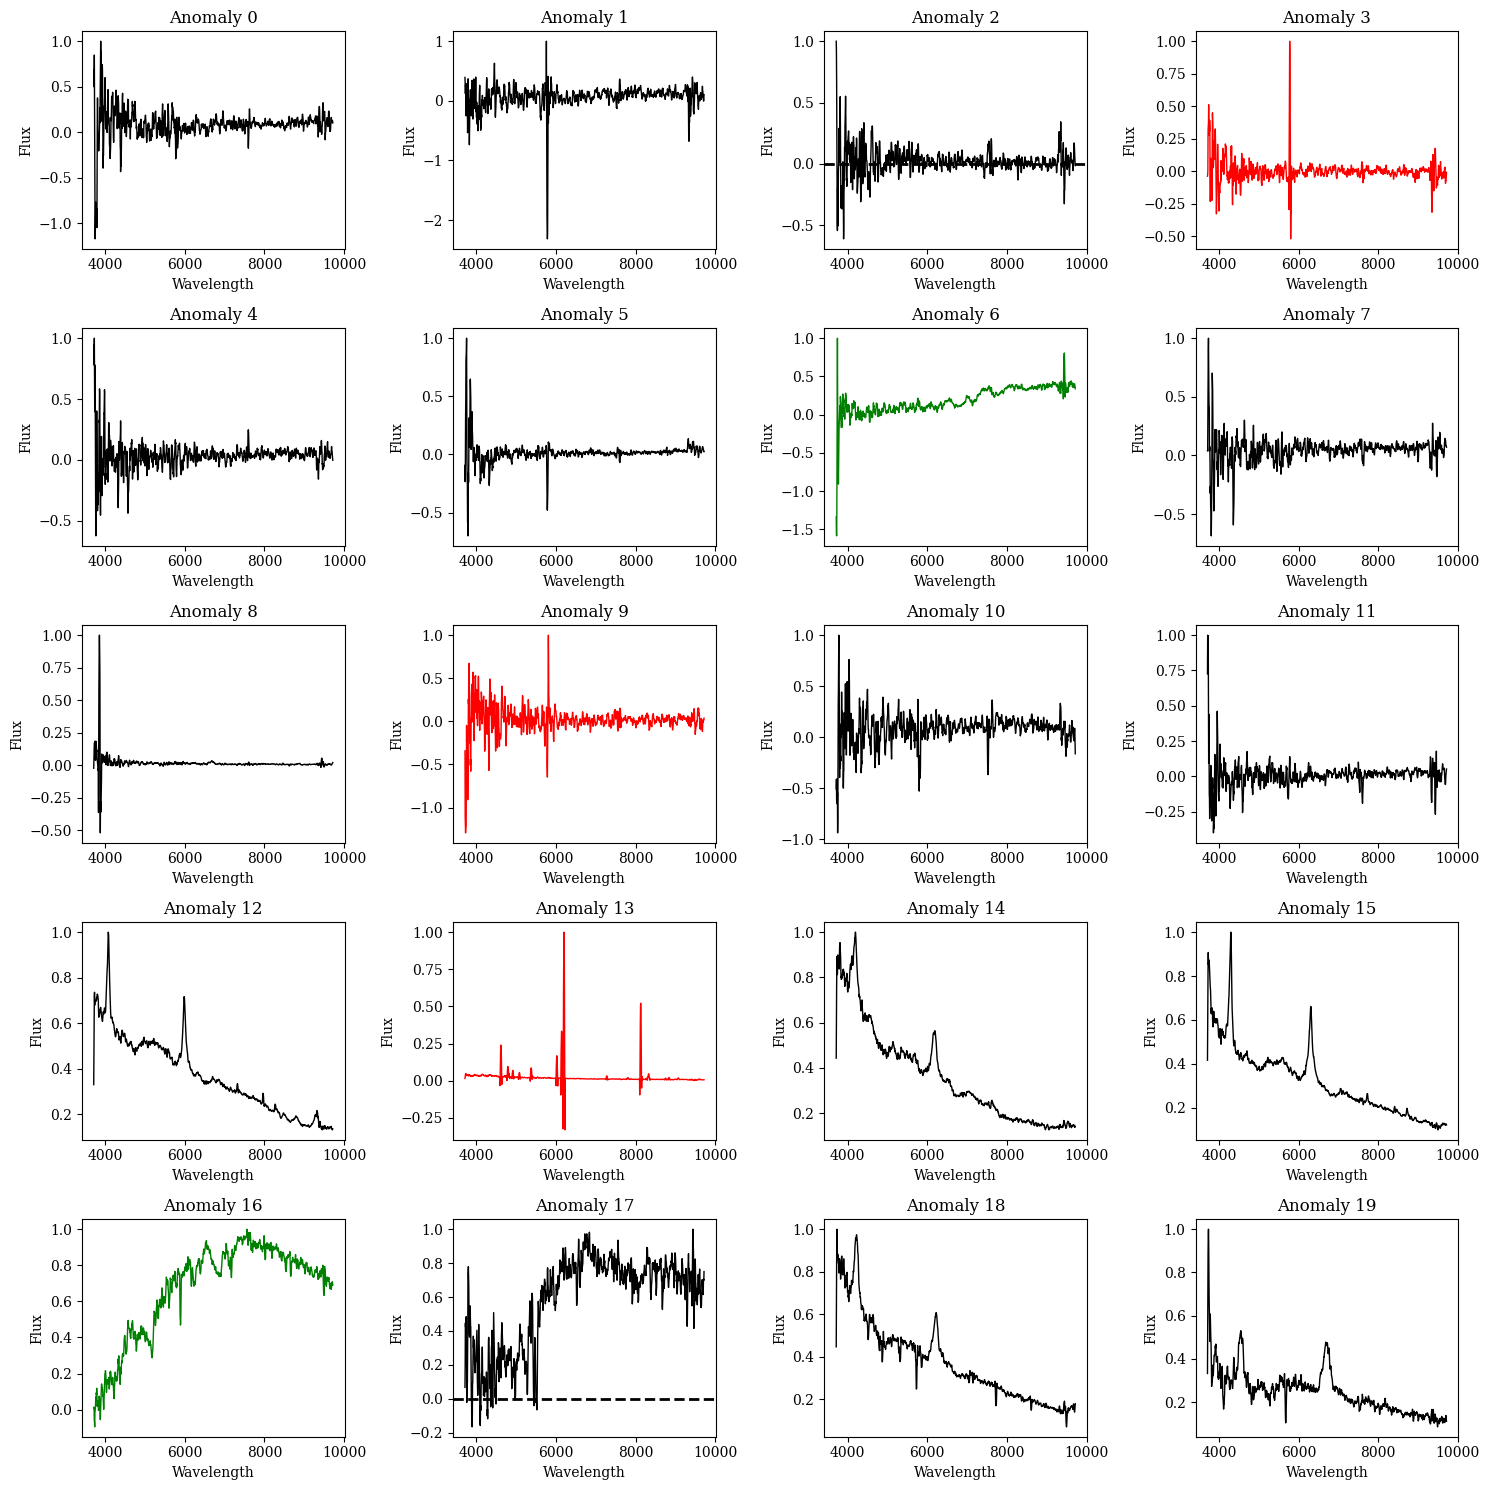

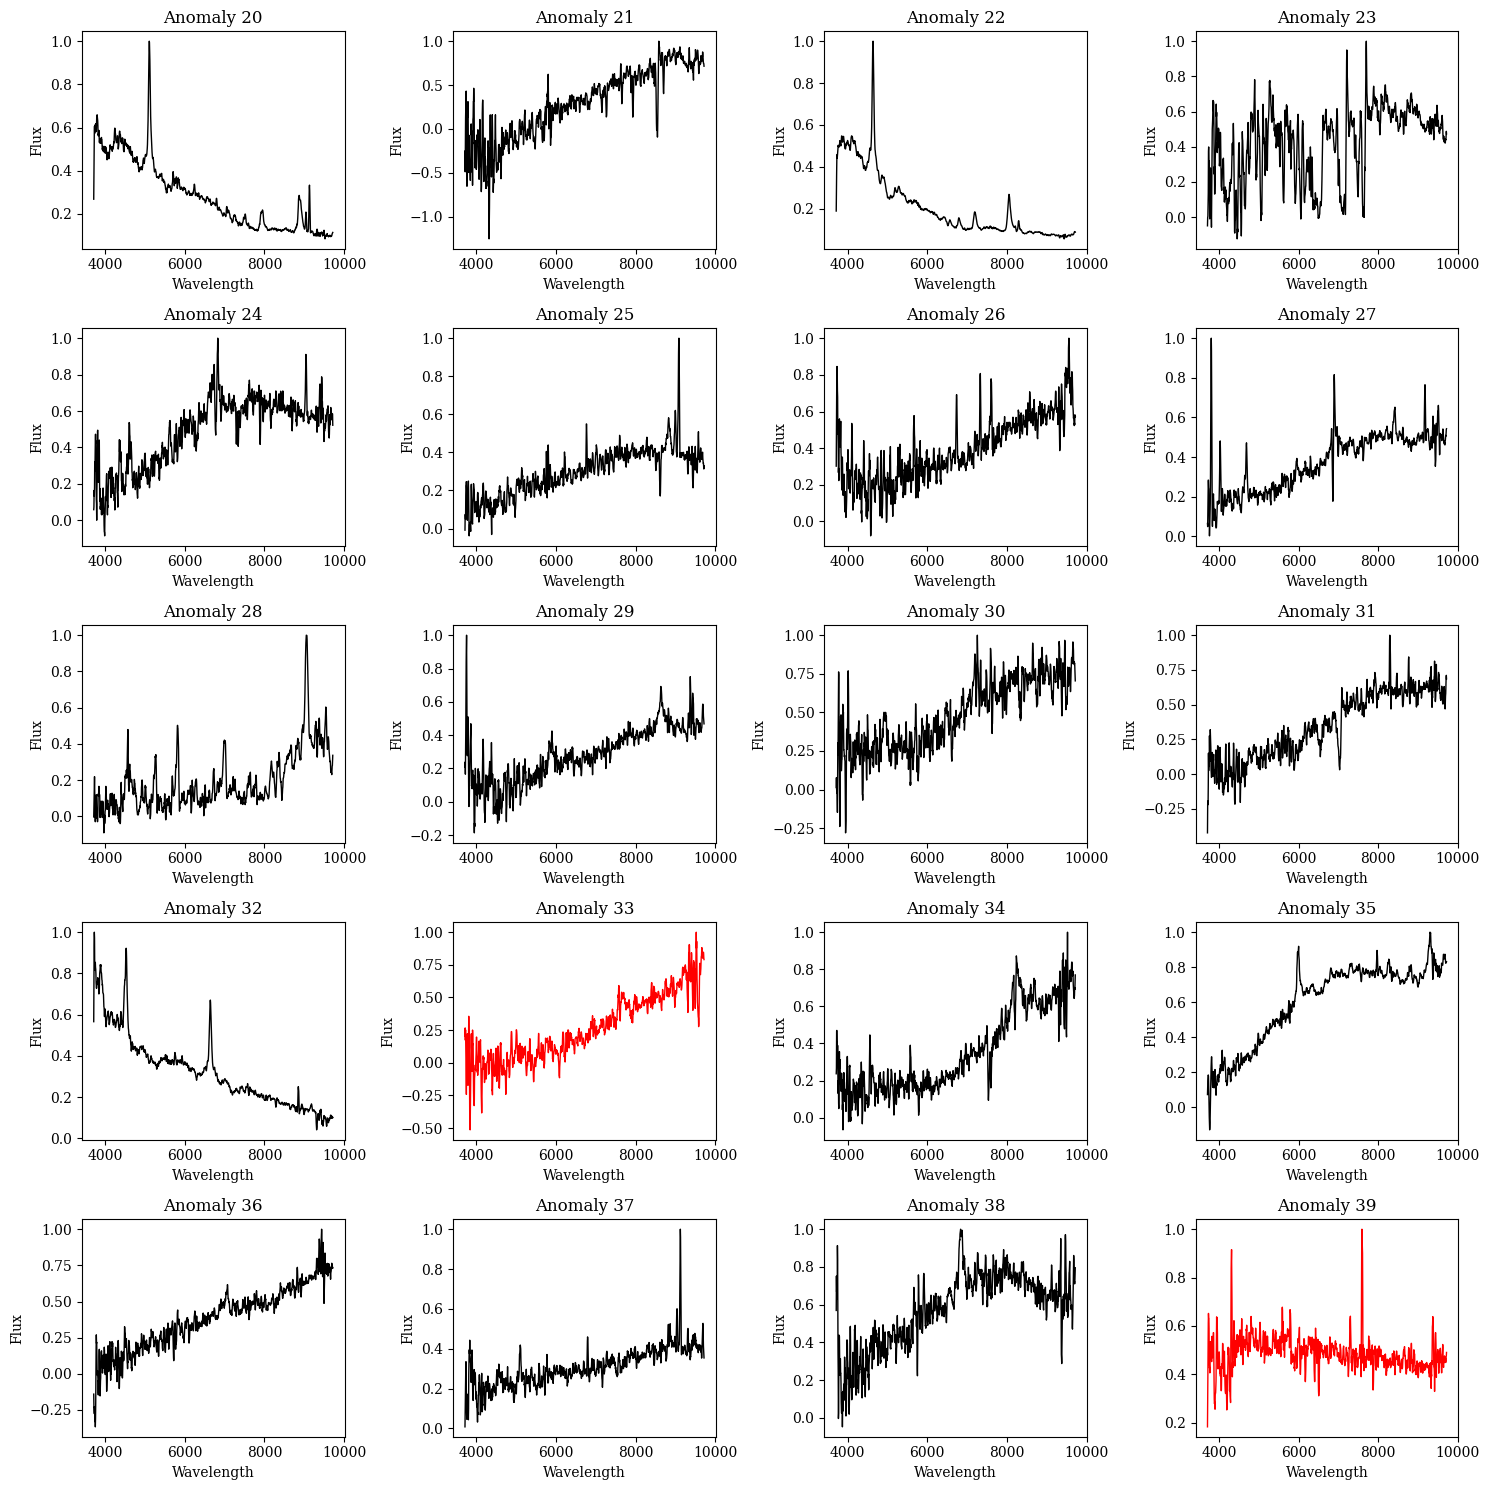

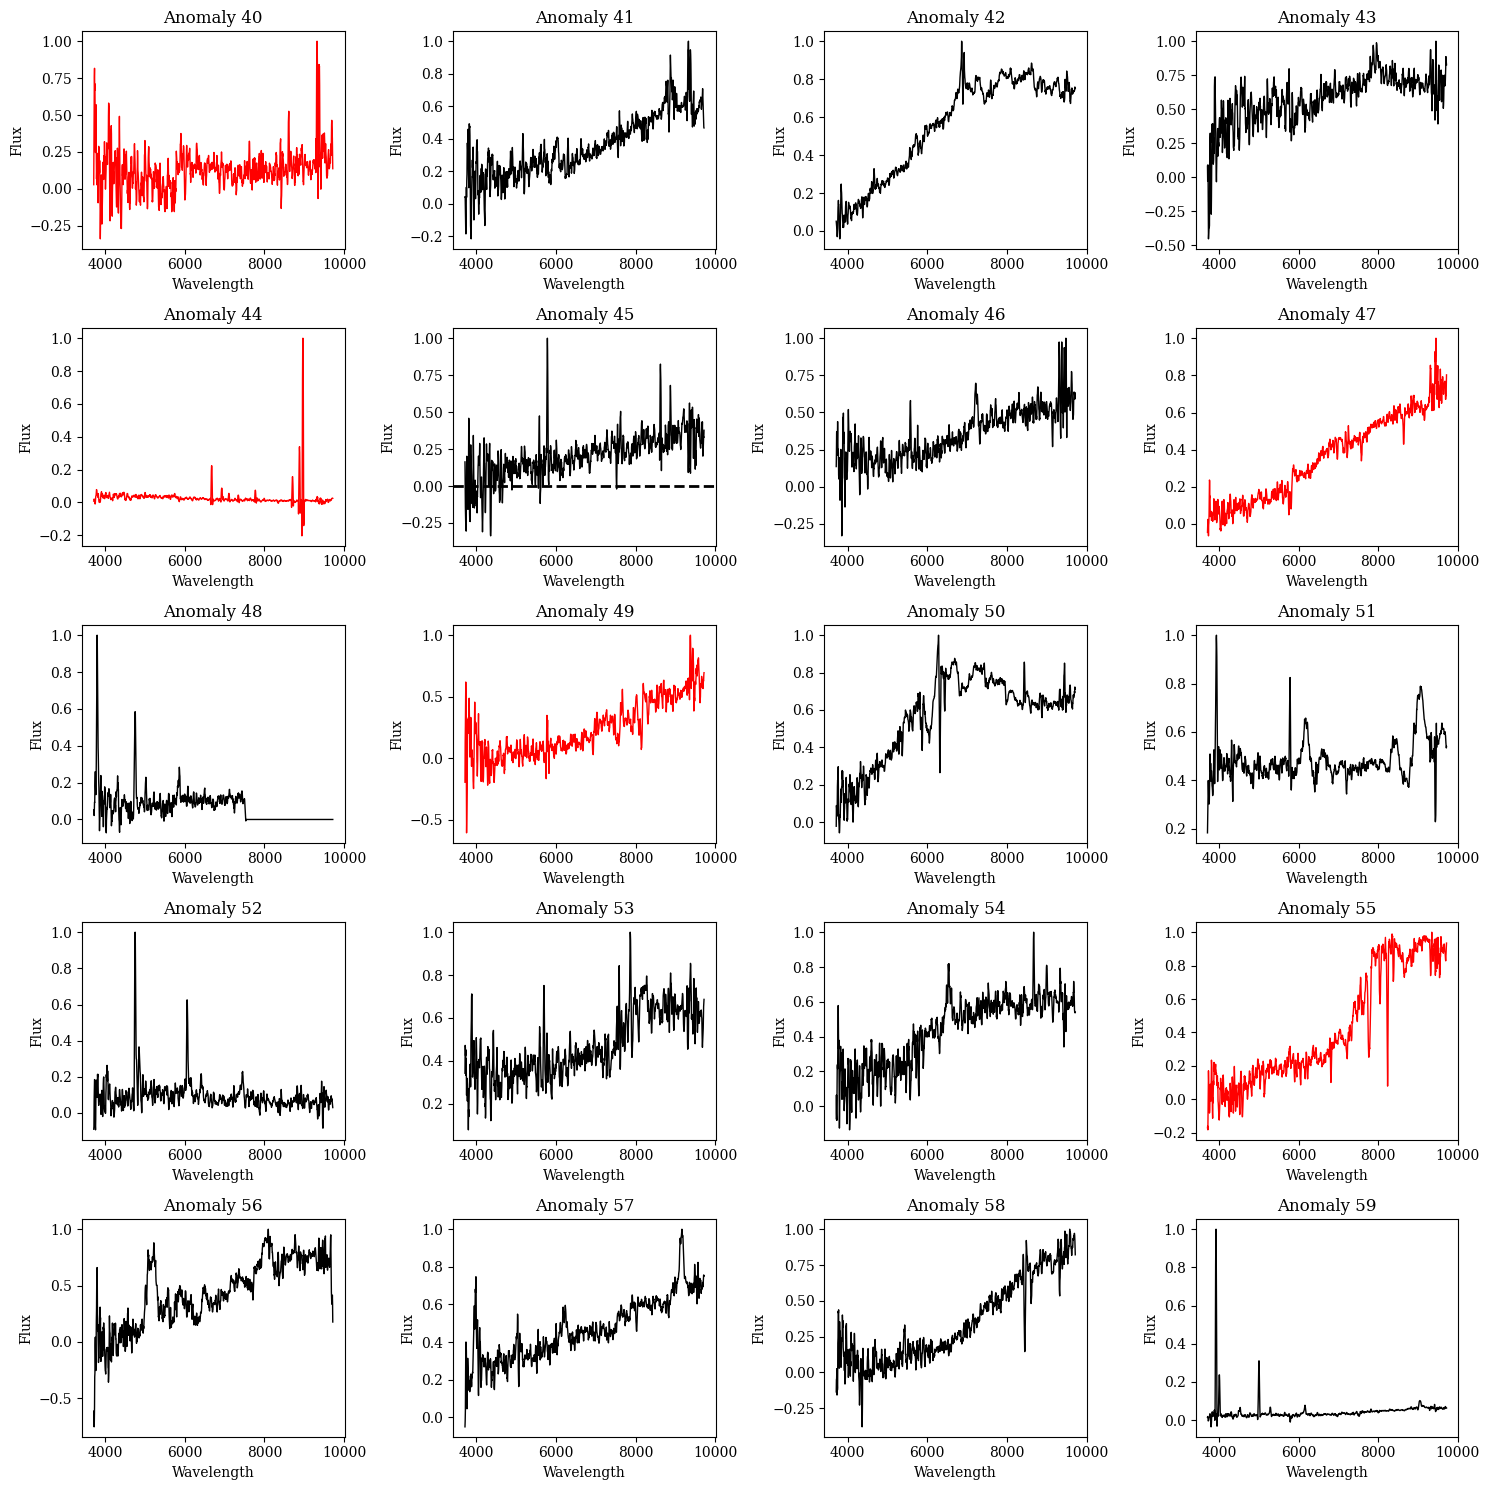

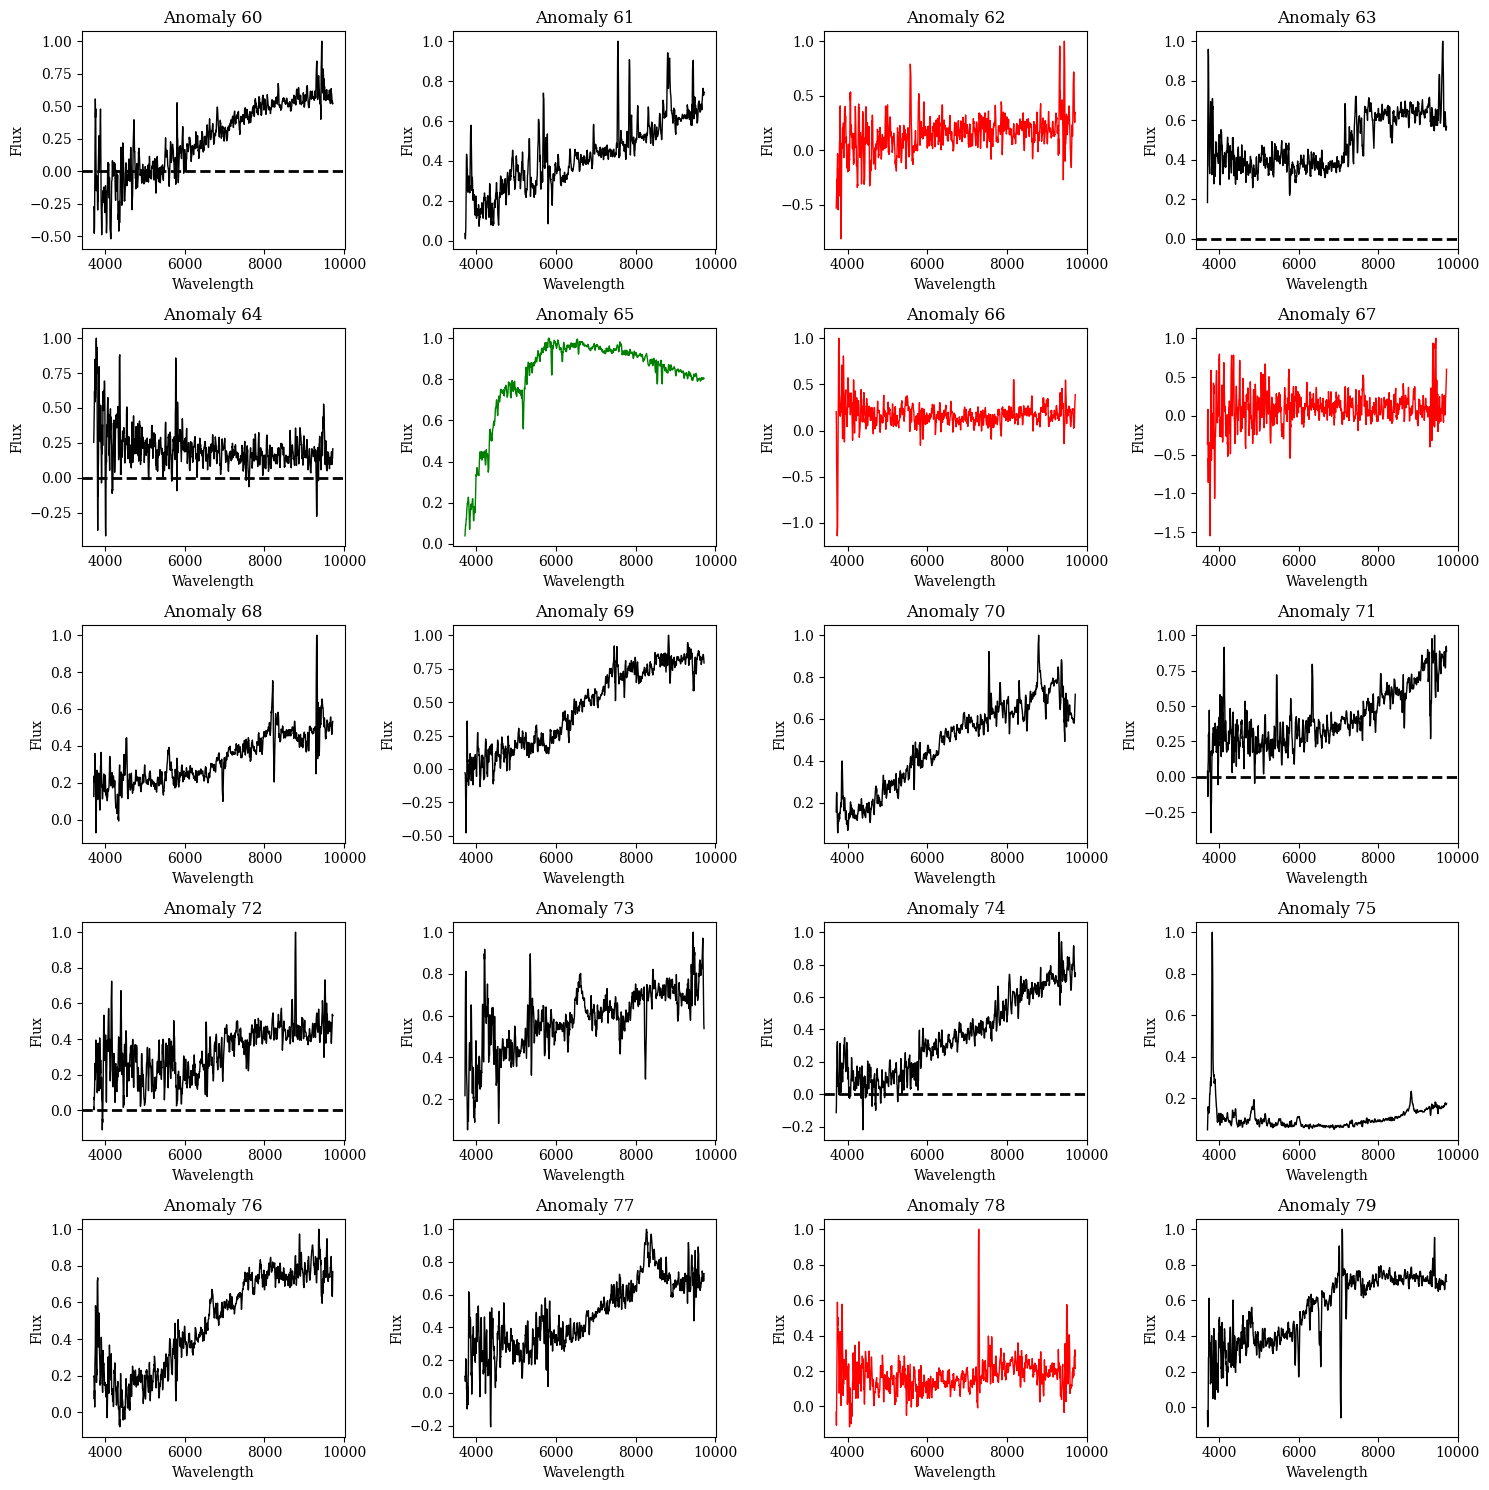

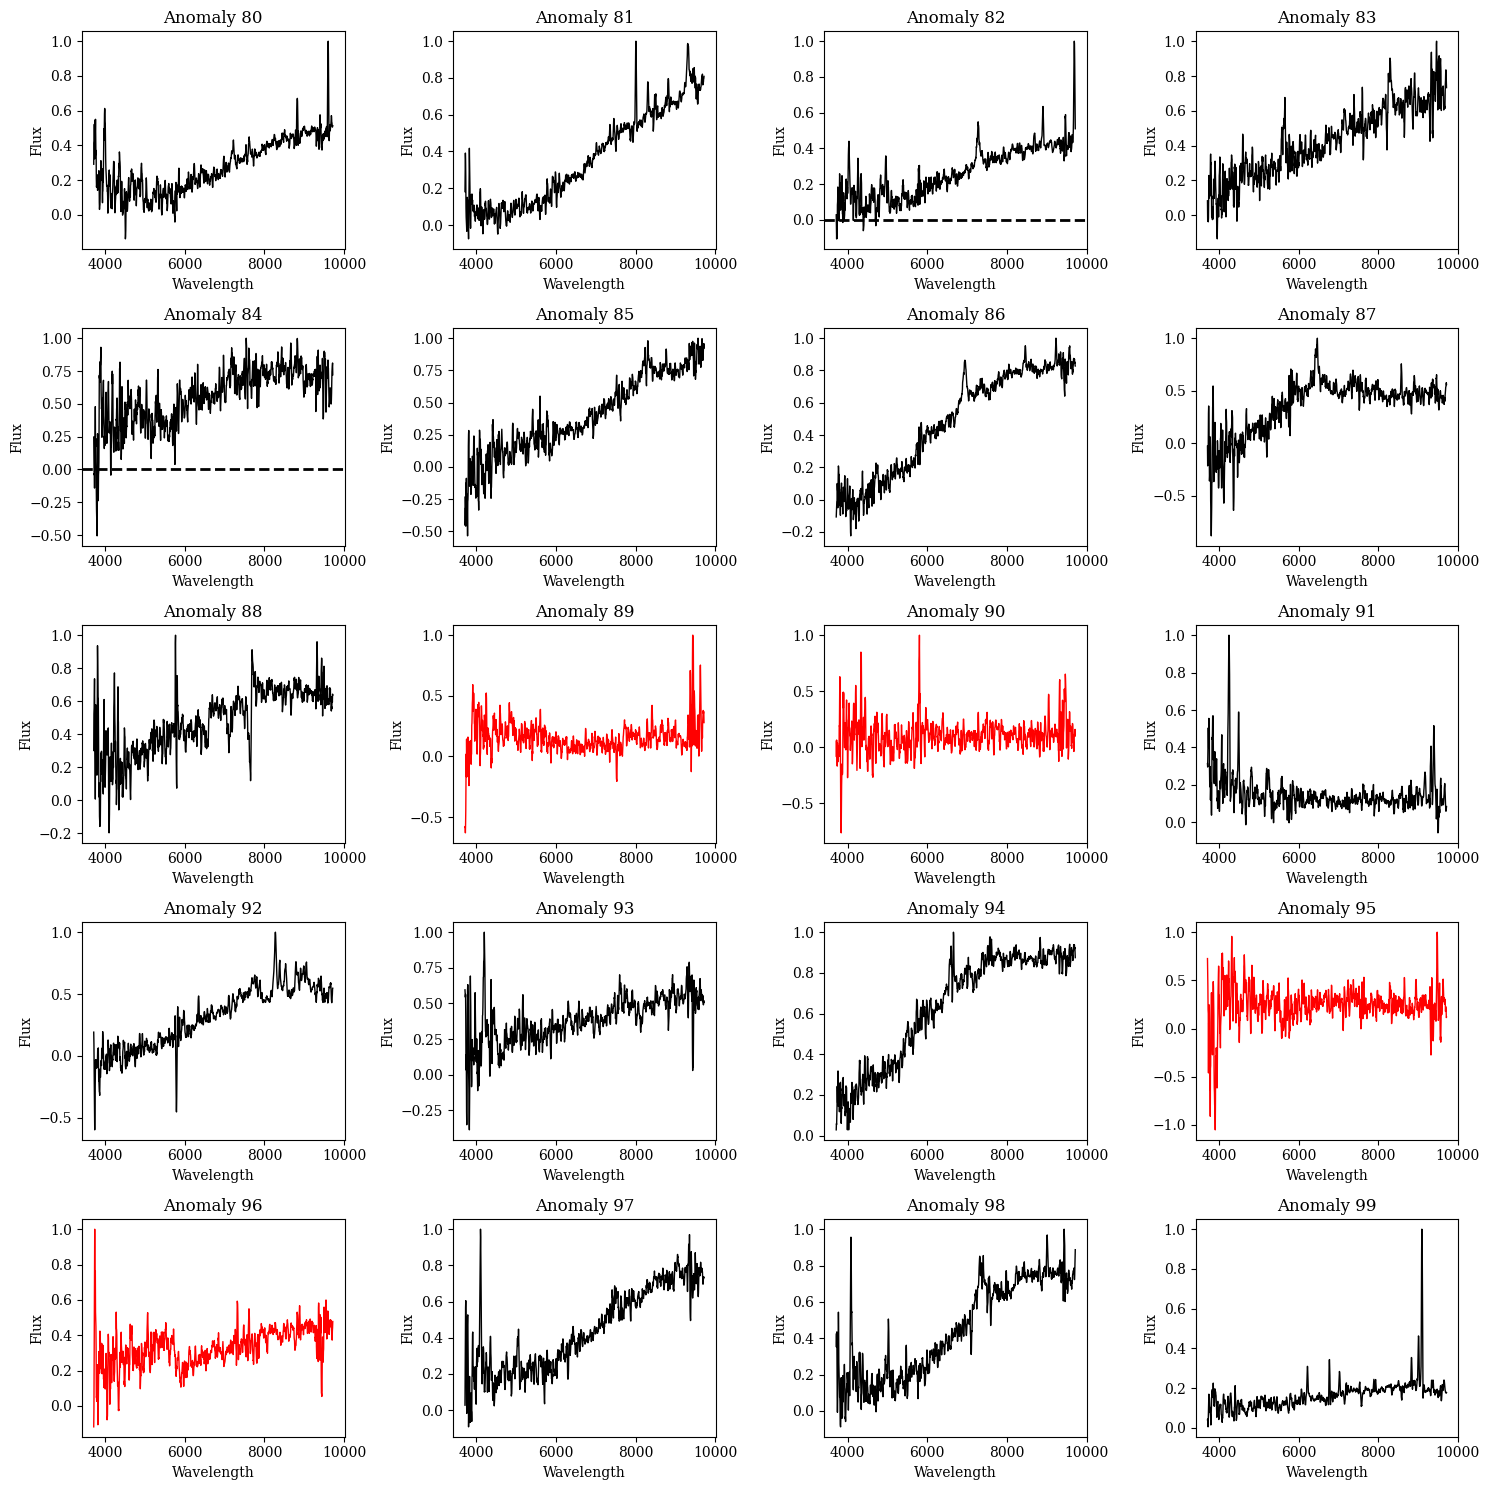

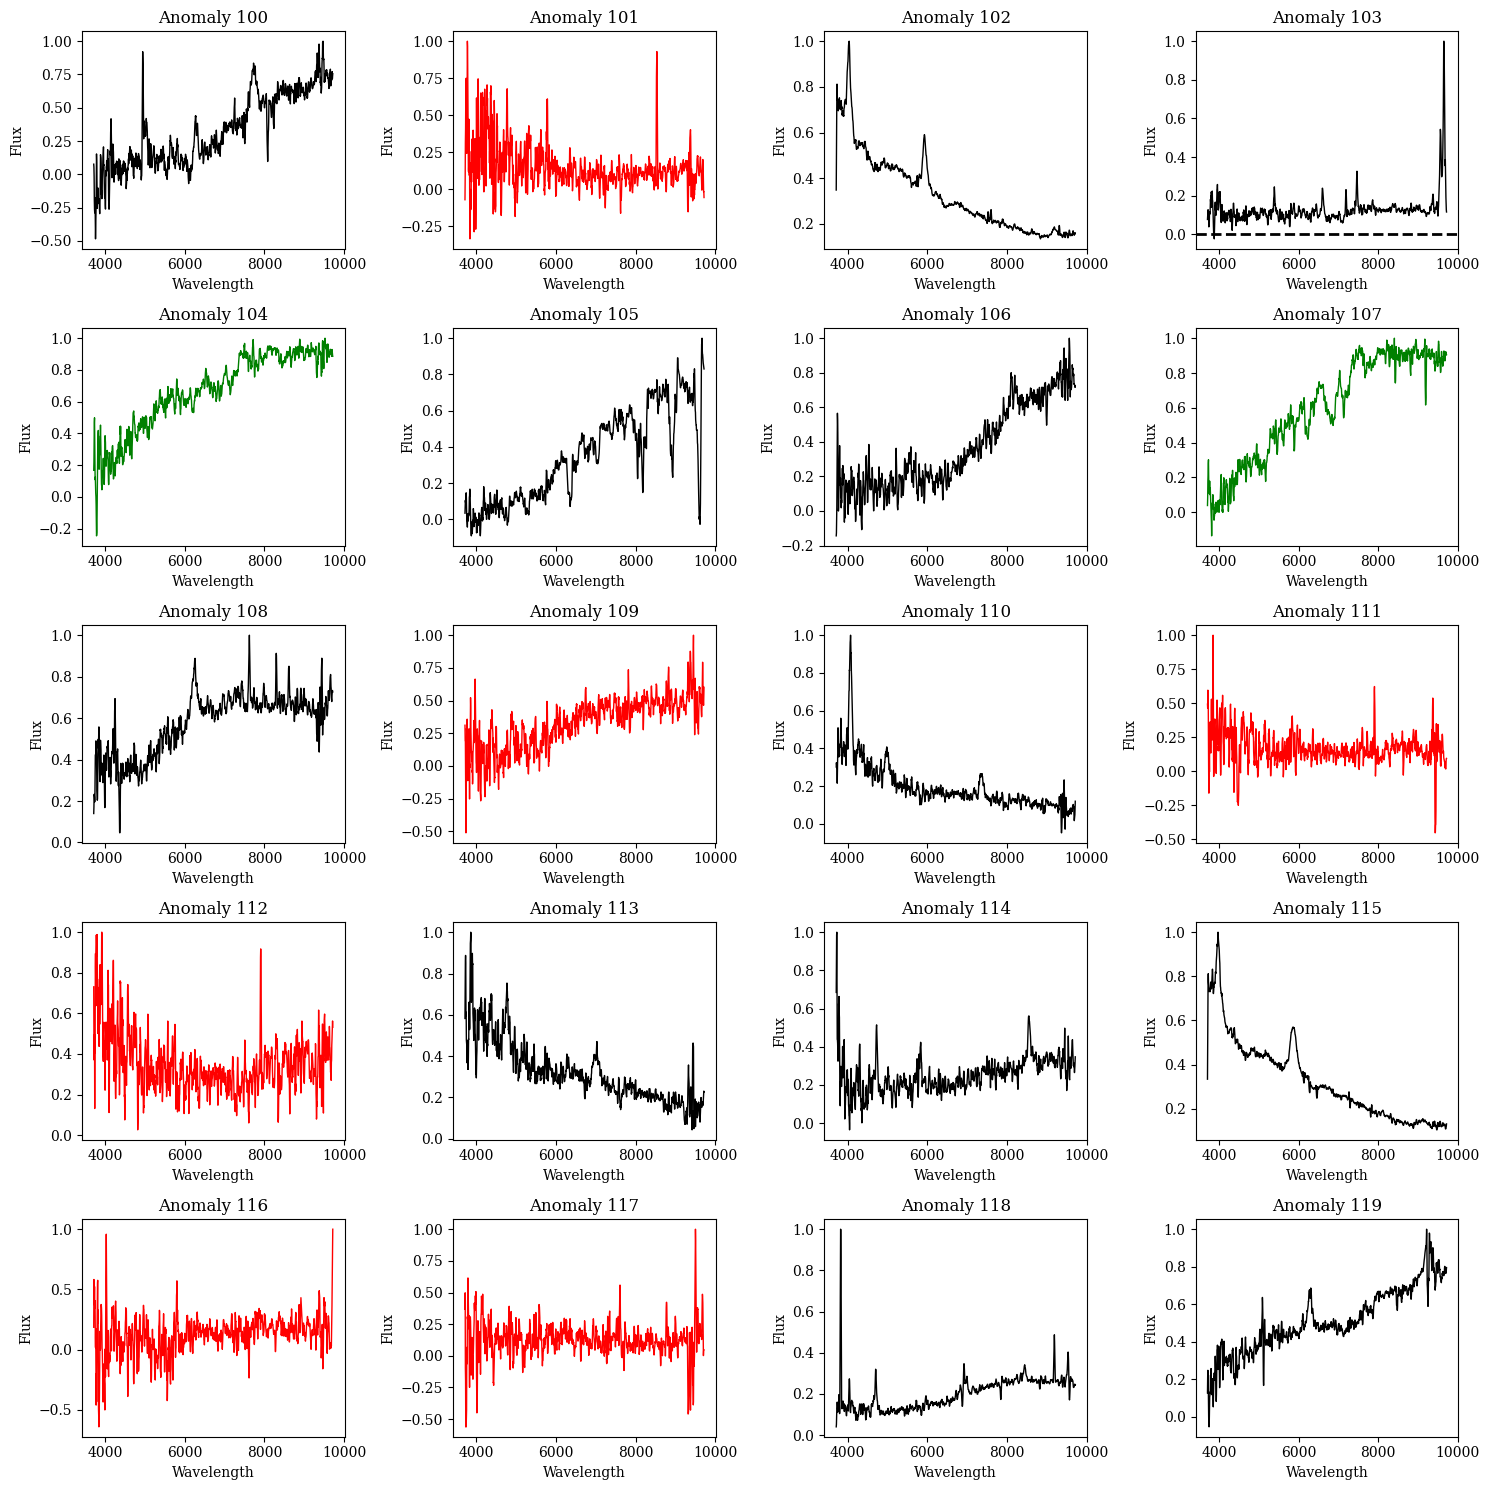

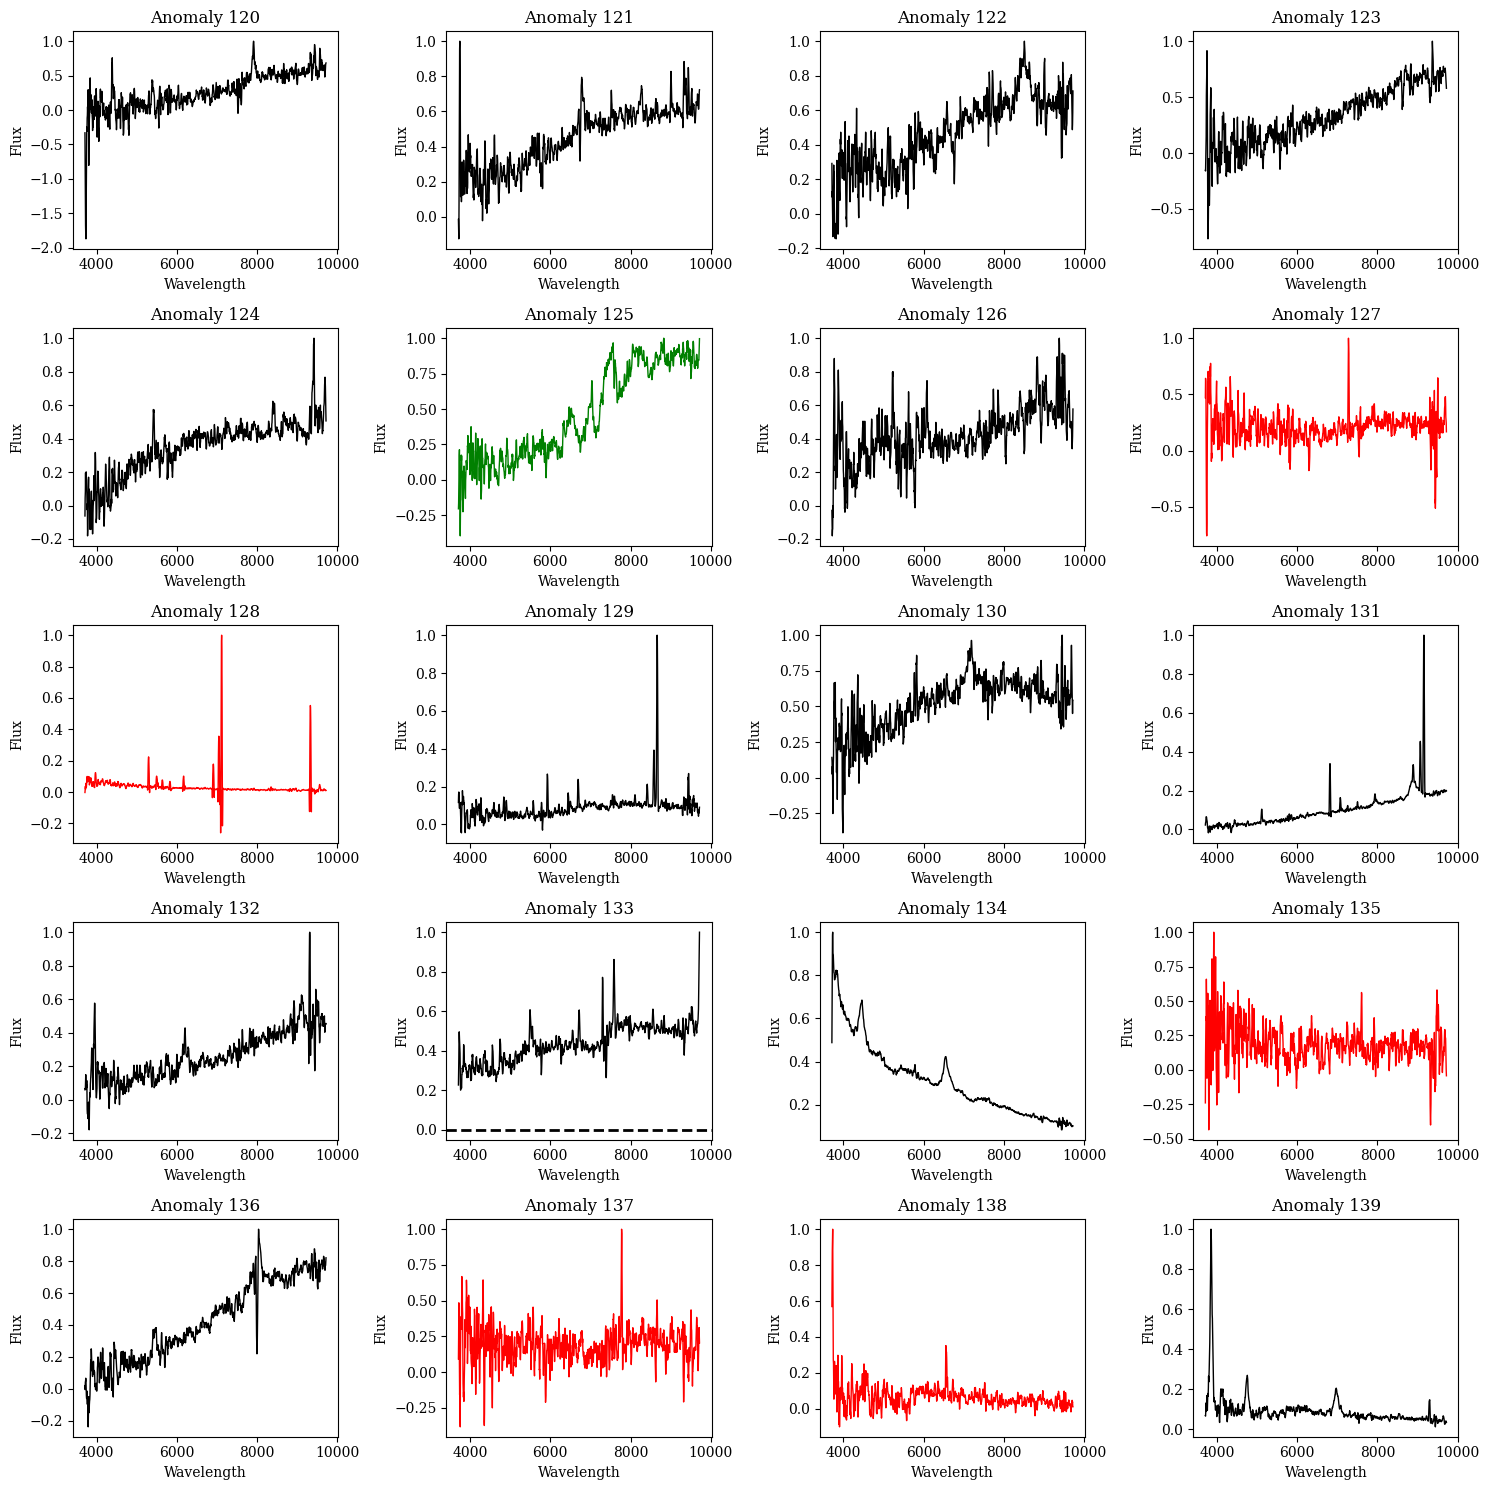

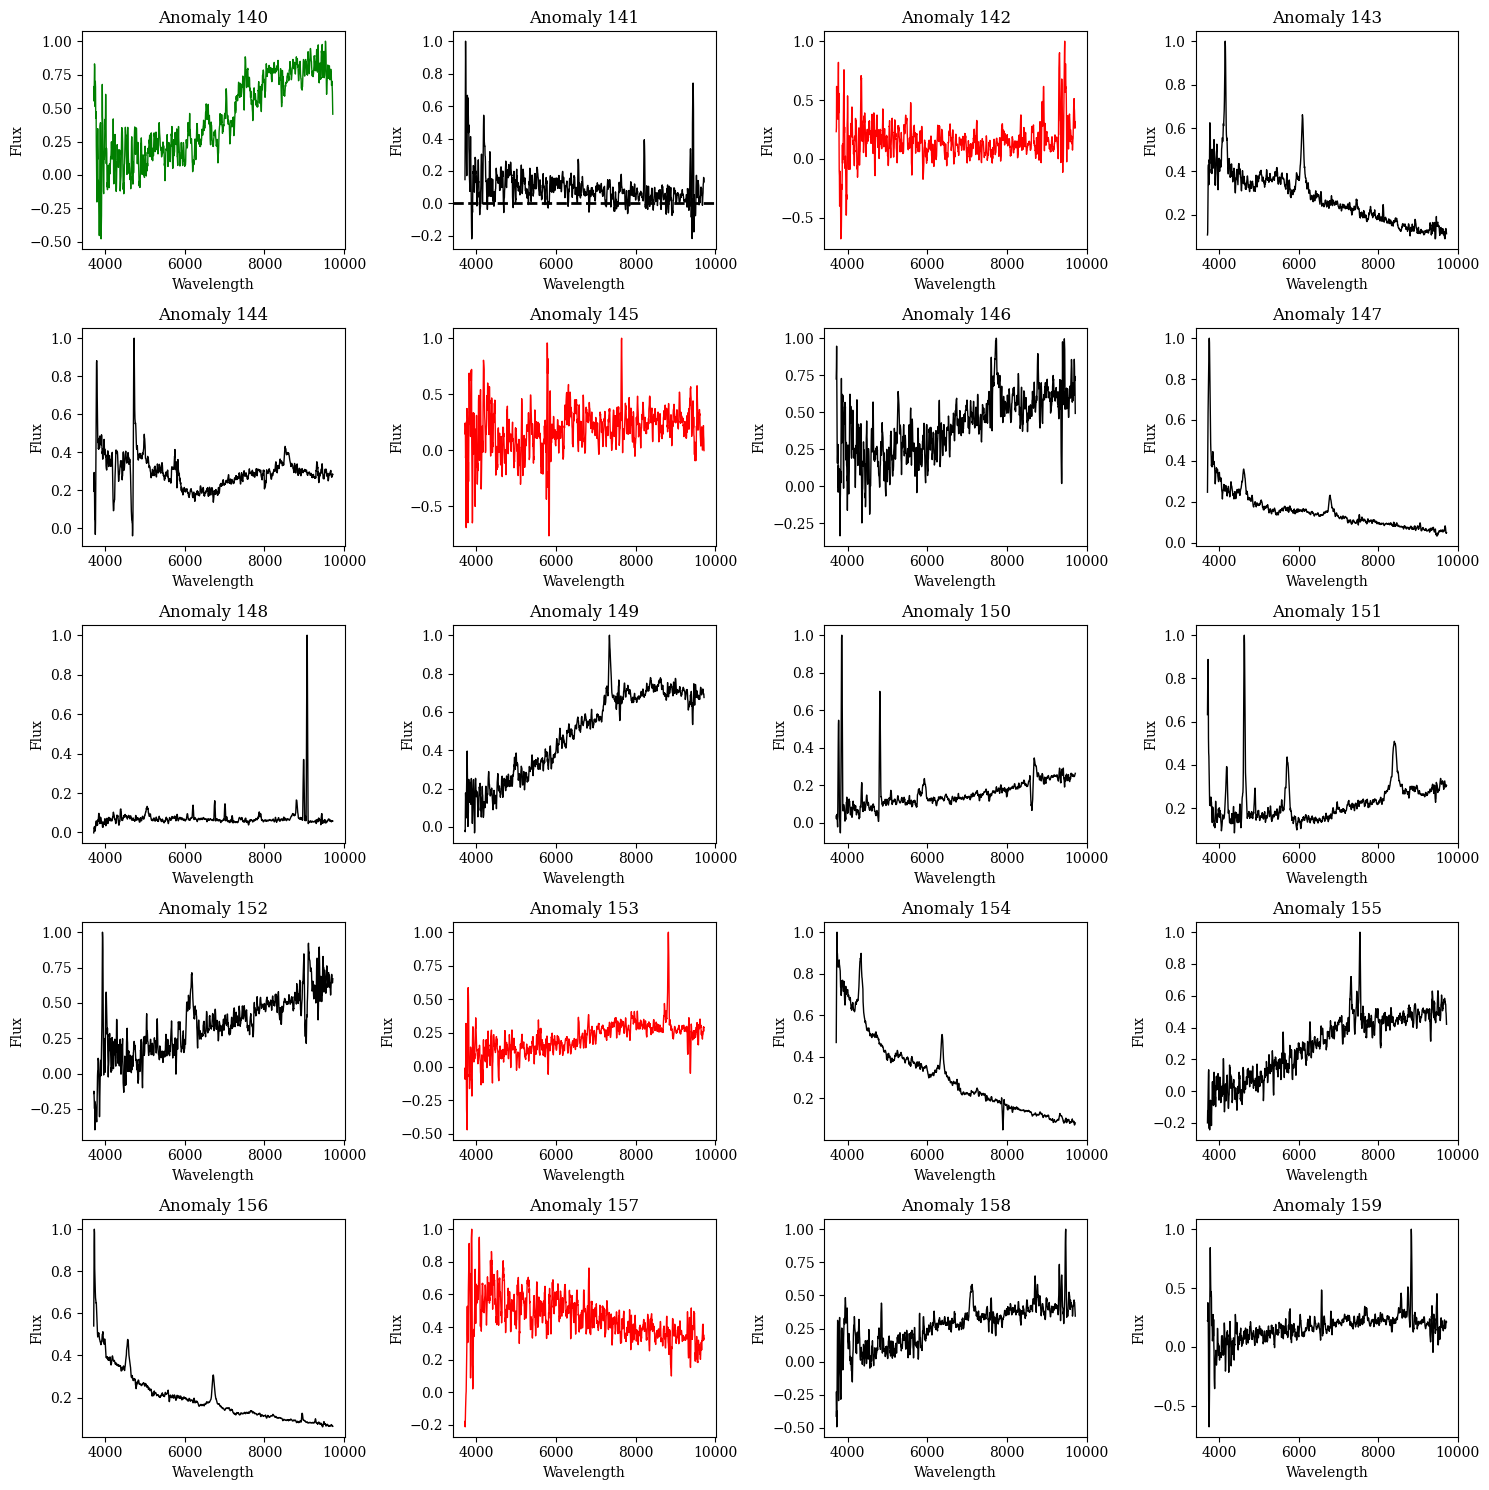

KeyError: 172

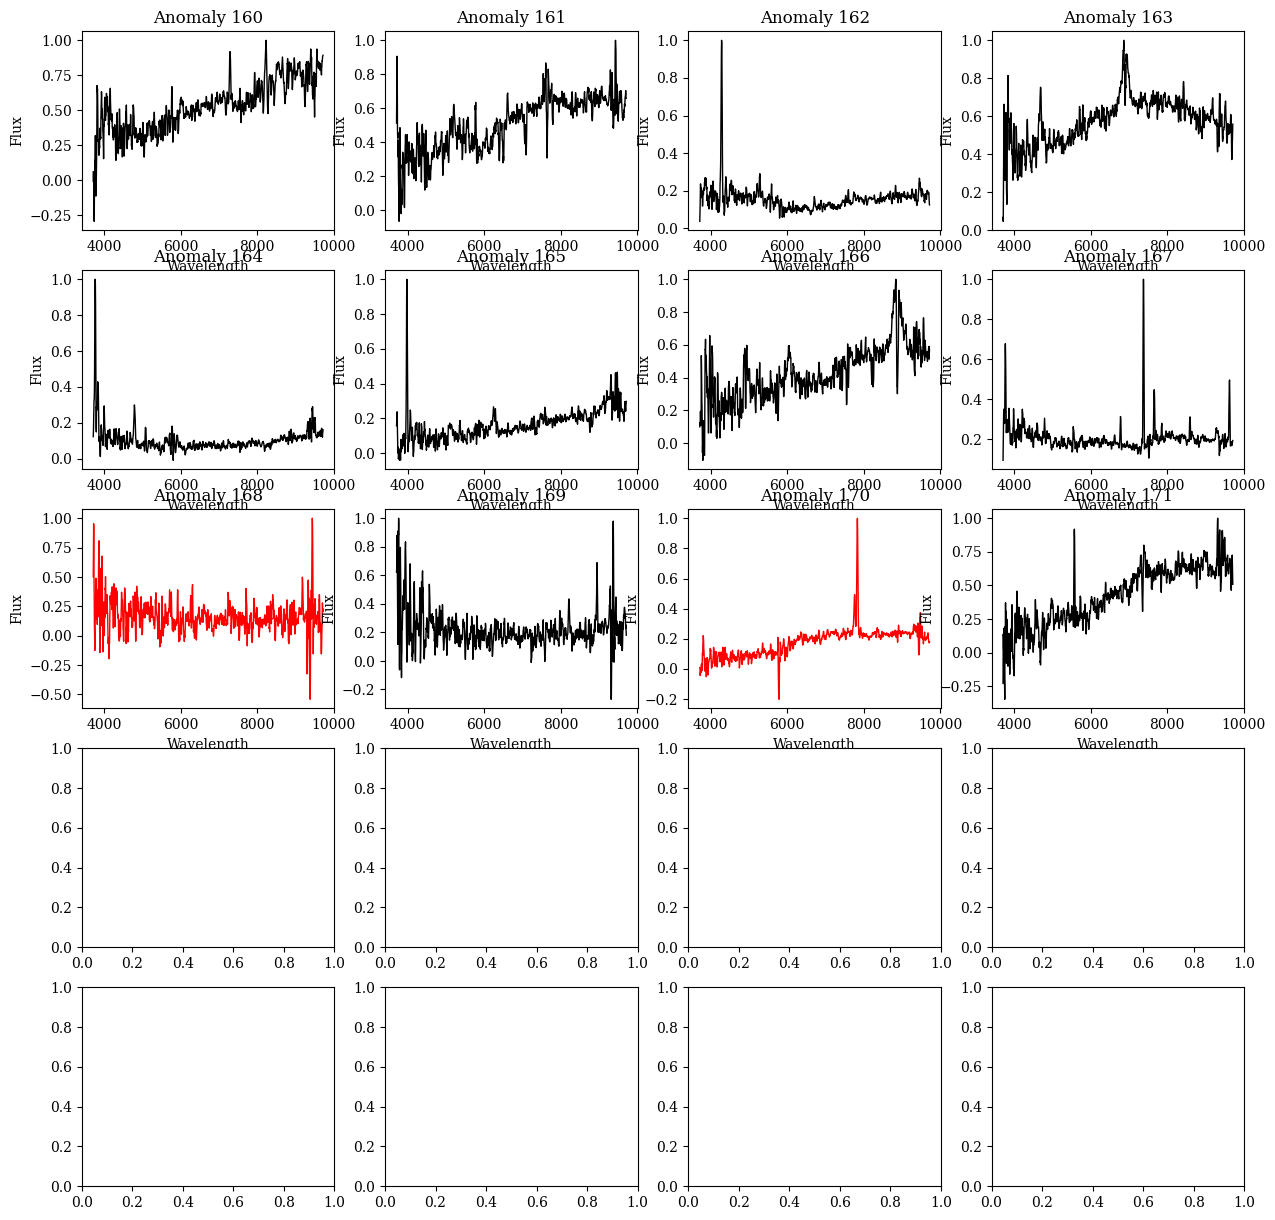

In [147]:
labels = df.STC
labels_pipeline = df.STP
cdict = {'QSO':'black','GALAXY':'red','STAR':'green'}

num_rows = 5
num_cols = 4
batch_size = 20

# Total number of batches
num_batches = len(df) // batch_size

# Loop through batches
for j in range(num_batches):
    # Create the subplots grid for each batch
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

    # Flatten the axes array to easily iterate over it
    axes = axes.flatten()

    # Plot each of the 20 spectra in the current batch
    for i in range(batch_size):
        ax = axes[i]
        ax.plot(new_wavs, df.iloc[i + j * batch_size][:-4],c=cdict[labels[i + j * batch_size]],lw=1)
        if labels[i + j * batch_size] != labels_pipeline[i + j * batch_size]:
            ax.axhline(0,lw=2,c='k',ls='--')
        ax.set_title(f"Anomaly {i + j * batch_size}")
        ax.set_xlabel("Wavelength")
        ax.set_ylabel("Flux")

    # Adjust layout to prevent overlapping
    plt.tight_layout()

    # Show the plot for the current batch
    plt.show()

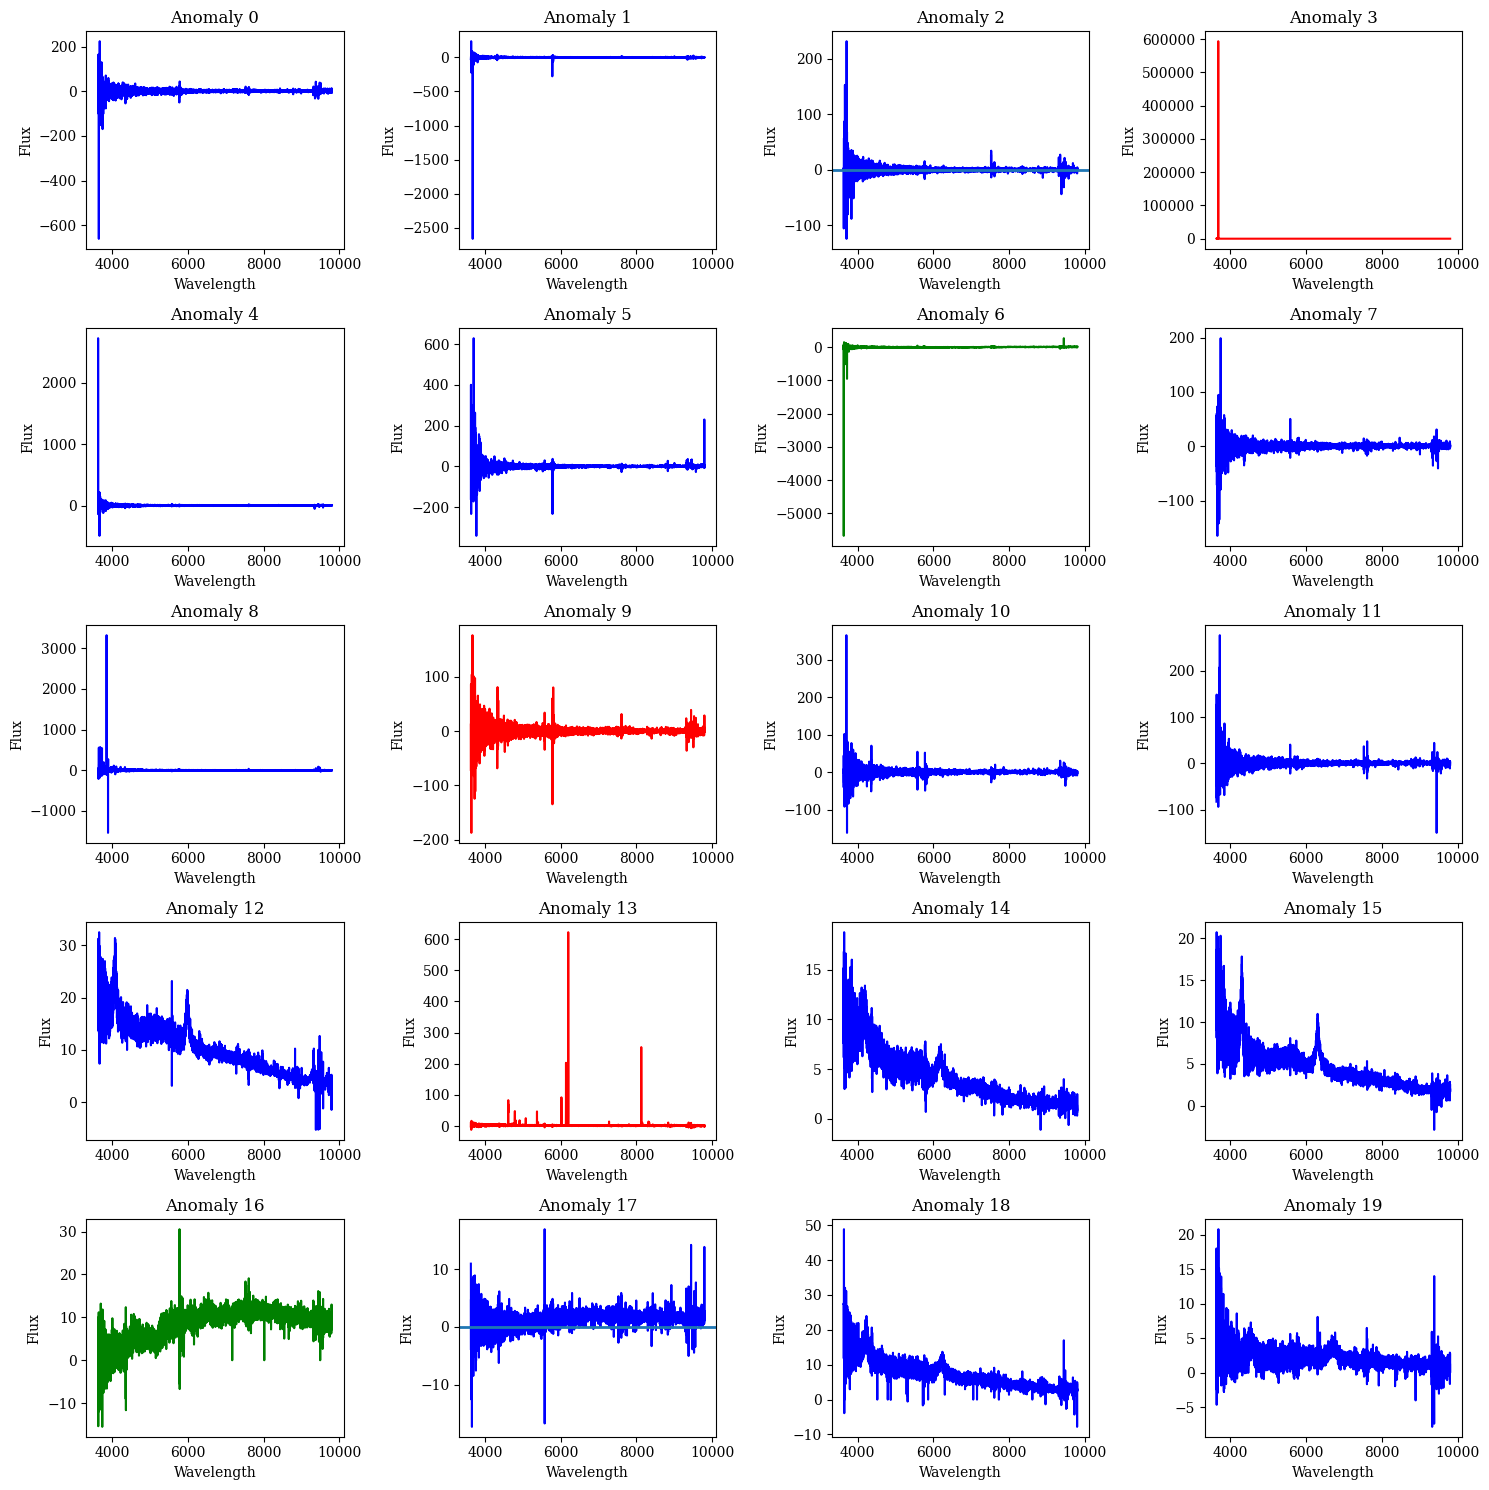

In [122]:
num_rows = 5
num_cols = 4
batch_size = 20

labels = df.STC
labels_pipeline = df.STP
cdict = {'QSO':'blue','GALAXY':'red','STAR':'green'}

# Total number of batches
num_batches = len(wavelength0) // batch_size

# Loop through batches
for j in range(1):
    # Create the subplots grid for each batch
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

    # Flatten the axes array to easily iterate over it
    axes = axes.flatten()

    # Plot each of the 20 spectra in the current batch
    for i in range(batch_size):
        ax = axes[i]
        ax.plot(wavelength0, Fluxes0[i + j * batch_size],c=cdict[labels[i + j * batch_size]])
        if labels[i + j * batch_size] != labels_pipeline[i + j * batch_size]:
            ax.axhline(0,lw=2)
        ax.set_title(f"Anomaly {i + j * batch_size}")
        ax.set_xlabel("Wavelength")
        ax.set_ylabel("Flux")

    # Adjust layout to prevent overlapping
    plt.tight_layout()

    # Show the plot for the current batch
    plt.show()